In [58]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv("cleaned_2014", low_memory = False);

In [4]:
data_train, data_test = train_test_split(df, test_size=.2, stratify=df.paid, random_state=1)

In [5]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 'term']
x_train_initial, y_train_initial = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [6]:
sm = SMOTE(random_state=1, ratio = 1.0)
x_train, y_train = sm.fit_sample(x_train_initial, y_train_initial)

In [7]:
x_train.shape

(283092, 48)

In [8]:
#create a function to take advantage of sklearn make_pipeline
#pipeline adds second order terms and interaction terms to X_train and then fits model
def rf_model(x, y, d):
    model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(max_depth = d, n_estimators = 100))
    model.fit(x, y)
    return model

rf_complex = rf_model(x_train, y_train, 10)

In [564]:
#create a function to take advantage of sklearn make_pipeline
#pipeline adds second order terms and interaction terms to X_train and then fits model
def logreg_model(x, y):
    model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(cv = 3, penalty = 'l2', max_iter = 10000))
    model.fit(x, y)
    return model

logreg_complex = logreg_model(x_train, y_train)

In [10]:
def create_df(data_1, data_2):
    df = pd.DataFrame(data_1)
    
    df['int_rate'] = data_2['int_rate']
    df['amnt'] = data_2['amnt']
    df['total_pymnt'] = data_2['total_pymnt']
    df['term'] = data_2['term']
    df['ROI'] = (df['int_rate'])*(1-df['proba'])

    df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term']))-1)
    df['annualized_amnt'] = df['amnt']*(1/df['term'])
    
    return df

In [11]:
train_data = {'proba' : rf_complex.predict_proba(x_train)[:, 1], 'true_val' : y_train}
test_data = {'proba' : rf_complex.predict_proba(x_test)[:, 1], 'true_val' : y_test}

df_train = create_df(train_data, data_train)
df_test =  create_df(test_data, data_test)

In [12]:
df_train.tail()

,proba,true_val,int_rate,amnt,total_pymnt,term,ROI,Real_ROI,annualized_amnt
283087,0.377900,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283088,0.409345,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283089,0.520768,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283090,0.495300,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283091,0.706906,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
baseline_train = np.mean(df_train.ROI)
baseline_test = np.mean(df_test.ROI)
print(baseline_train, baseline_test)
alpha_low = 1
alpha_high = np.inf

0.07159880320557449 0.06891758765232457


In [51]:
loans_to_buy_train = df_train[(df_train.ROI > alpha_low*baseline_train) & (df_train.ROI < alpha_high*baseline_train)]
loans_to_buy_test = df_test[(df_test.ROI > alpha_low*baseline_test) & (df_test.ROI < alpha_high*baseline_test)]

In [52]:
loans_to_buy_train

,proba,true_val,int_rate,amnt,total_pymnt,term,ROI,Real_ROI,annualized_amnt
3,0.221747,0,0.1366,9600.0,9973.430000,3.0,0.106309,122.896662,3200.000000
4,0.531941,0,0.1559,21425.0,25512.200000,5.0,0.072970,761.369757,4285.000000
5,0.179010,0,0.1786,12975.0,5746.890000,3.0,0.146629,-3084.554082,4325.000000
6,0.469675,0,0.1366,17000.0,19562.310001,3.0,0.072442,814.459898,5666.666667
7,0.370055,0,0.1144,16000.0,18586.720000,5.0,0.072066,486.806372,3200.000000
13,0.198060,0,0.1049,6000.0,6839.302523,3.0,0.084123,267.650508,2000.000000
18,0.473958,1,0.1499,6000.0,6849.320000,3.0,0.078854,270.709076,2000.000000
19,0.198095,0,0.1239,7200.0,8645.094132,3.0,0.099356,452.645104,2400.000000
21,0.323042,0,0.1431,18450.0,9387.620000,3.0,0.096873,-3720.678303,6150.000000
27,0.412377,1,0.1431,2000.0,2465.422148,3.0,0.084089,144.455778,666.666667


In [53]:
def return_performance(df_sub, df_main):
    perf_subset = np.sum(df_sub.Real_ROI)/np.sum(df_sub.annualized_amnt)
    perf_mainset = np.sum(df_main.Real_ROI)/np.sum(df_main.annualized_amnt)
    return (perf_subset, perf_mainset, perf_subset - perf_mainset)

In [54]:
training_set_performance = return_performance(loans_to_buy_train, df_train)
testing_set_performance = return_performance(loans_to_buy_test, df_test)

In [55]:
print(training_set_performance)
print(testing_set_performance)

(0.02716982688448818, 0.04888950141479454, -0.02171967453030636)
(0.06907974218942813, 0.049272700564121655, 0.01980704162530647)


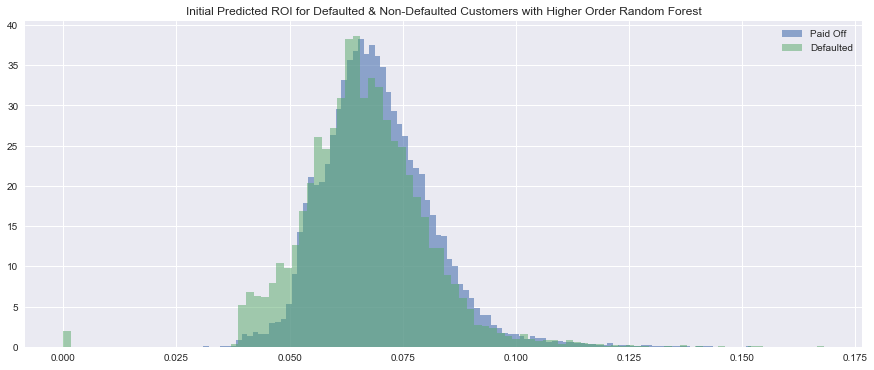

In [40]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(df_test.loc[df_test.true_val == 0,'ROI'], density = True, bins = 100, label='Paid Off', alpha=0.6);
ax.hist(df_test.loc[df_test.true_val == 1,'ROI'], density = True, bins = 100, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Higher Order Random Forest')
ax.legend(loc='best')

plt.show()

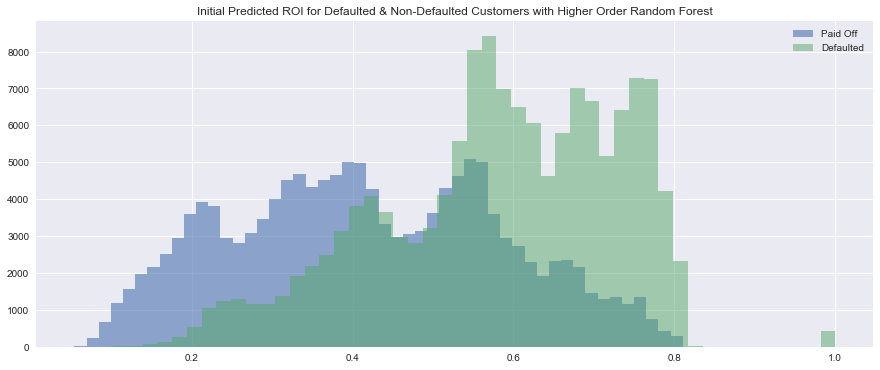

In [57]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(df_train.loc[df_train.true_val == 0,'proba'], bins = 50, label='Paid Off', alpha=0.6);
ax.hist(df_train.loc[df_train.true_val == 1,'proba'], bins = 50, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Higher Order Random Forest')
ax.legend(loc='best')

plt.show()